In [1]:
import numpy as np 
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('fivethirtyeight')

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', 1000, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mp.style.use('ggplot')
sns.set(style='whitegrid')

import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing,metrics 
from sklearn.decomposition import PCA 
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import ElasticNet, Ridge, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# from sklearn.metrics import mean_squared_error, mean_absolute_error

/Users/april/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [62]:
df = pd.read_json('input/CleanedData.json', orient='table')
df = df[[c for c in df if c not in ['loan_status']] + ['loan_status']]

#### 1. Train Test Split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], 
                                                    df.iloc[:,-1], 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                   stratify=df.iloc[:,-1])

In [64]:
y_train.mean(), y_test.mean(), X_train.shape, X_test.shape

(0.15745980631259915, 0.15747975564710898, (42233, 85), (14078, 85))

#### 2. Short list

In [65]:
short_cols = ['tot_hi_cred_lim', 'mort_acc', 'avg_cur_bal', 'fico_range_low',
       'loan_amnt', 'bc_open_to_buy', 'term', 'home_ownership',
       'total_acc', 'num_il_tl', 'total_rev_hi_lim', 'revol_util',
       'mo_sin_old_il_acct', 'mths_since_recent_inq', 'emp_length',
       'inq_last_6mths', 'dti', 'all_util', 'annual_inc', 'open_il_24m',
       'emp_length_present', 'mo_sin_old_il_acct_present',
       'mths_since_rcnt_il_present', 'mths_since_last_major_derog',
       'max_bal_bc', 'mths_since_rcnt_il', 'revol_bal']

In [66]:
X_train = X_train[short_cols]
X_test = X_test[short_cols]

#### 3 Models

- Hyper-parameter tuning
  - Grid Search
  - Random Search
  - Bayesian 
- Model Evaluation 
  - Confusion Matrix
  - ROC 
  - KS Plot
  - Recall -precision



#### 3.1 -  Xgboost

In [7]:
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")


In [8]:
def xgbfit(alg, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds)
        
        alg.set_params(n_estimators=cvresult.shape[0])
        print('Best iteration: %.0g' % alg.get_params()['n_estimators'])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    print ("\nModel Report")
    print ("Accuracy : %.4g on Training" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print ("AUC Score (Train): %f on Training" % metrics.roc_auc_score(y_train, dtrain_predprob))
    
    #Print model report on testing sample
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    print ("\nModel Report")
    print ("Accuracy : %.4g on Testing" % metrics.accuracy_score(y_test.values, dtest_predictions))
    print ("AUC Score (Train): %f on Testing" % metrics.roc_auc_score(y_test, dtest_predprob))
                    
    fig, ax = plt.subplots(figsize=(12,5))
    xgb.plot_importance(alg, max_num_features=15, height=0.8, importance_type='gain', ax=ax)
    plt.show()

In [9]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.1,
 objective= 'binary:logistic',
 verbosity = 0,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

#xgb1.fit(X_train_new, y_train);

Best iteration: 1e+03

Model Report
Accuracy : 0.8467 on Training
AUC Score (Train): 0.754526 on Training

Model Report
Accuracy : 0.8438 on Testing
AUC Score (Train): 0.726183 on Testing


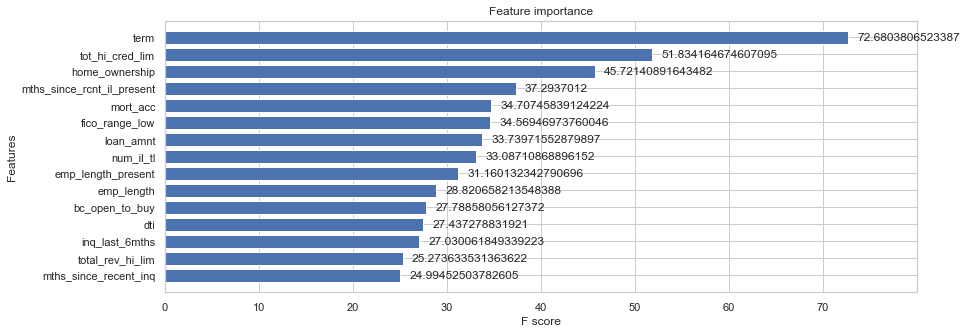

In [10]:
xgbfit(xgb1, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=20)

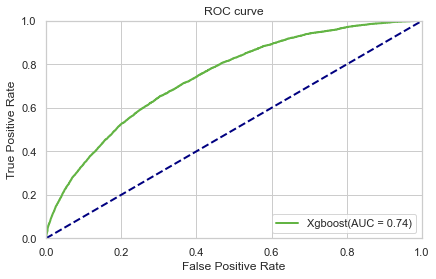

In [43]:
plotAUC(y_train,xgb1.predict_proba(X_train)[:,1], 'Xgboost')
plt.show()

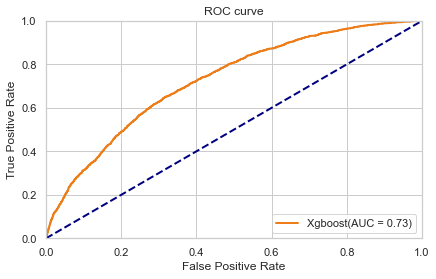

In [14]:
plotAUC(y_test,xgb1.predict_proba(X_test)[:,1], 'Xgboost')
plt.show()

#### 6.2 -  Logistic Regression with Grid Search

In [83]:
def missing_by_br(df, cols, label):
    tmp = df
    for col in cols:
        tmp['group'] = pd.qcut(tmp[col], 10, duplicates='drop')
        tmp['group'] = np.where(tmp.group.isna(), 'missing', tmp.group).astype(str)
        aa = tmp.groupby('group').agg({col: np.median,label: np.mean}).reset_index().rename(columns={'loan_status':'default_rate'}).sort_values(col).reset_index(drop = True)
        br = aa[aa['group'] == 'missing'].default_rate
        bb = aa.default_rate - br.iloc[0]
        aa['diff'] = bb.abs()
        aa = aa.sort_values('diff')
        imp = aa.iloc[1,2]
        tmp[col] = tmp[col].fillna(imp)
        tmp.drop(columns = {'group'}, inplace = True)
    
    return tmp

In [84]:
na_cols = df.columns[df.isnull().any()]
label = 'loan_status'
data = missing_by_br(df, na_cols, label)

In [93]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = data.columns.values[:-1]
data_clean = pd.DataFrame(scl.fit_transform(data[fields]), columns = fields)
data_clean['loan_status'] = data['loan_status'].reset_index(drop=True)
data_clean['loan_status'].value_counts()

0    47444
1     8867
Name: loan_status, dtype: int64

In [94]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(data.iloc[:,:-1], 
                                                    data.iloc[:,-1], 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                   stratify=data.iloc[:,-1])

X_train_new = X_train_new[short_cols]
X_test_new = X_test_new[short_cols]

#### Logistic Regression with Grid Search

In [95]:
from sklearn.model_selection import GridSearchCV
def cross_validation_best_parameters(model, param_grid, X, y):
    grid = GridSearchCV(model, param_grid,cv=10, scoring='roc_auc')
    grid.fit(X,y)
    mean_scores = grid.cv_results_['mean_test_score']
    return mean_scores, grid.best_score_, grid.best_estimator_

In [96]:
logreg = LogisticRegression(random_state=0)
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(C=c)
mean_scores,Best_Accuracy, Best_classifier = cross_validation_best_parameters(logreg,param_grid, X_train_new, y_train)
print("Best auc is "+ str(Best_Accuracy))
print(Best_classifier)

Best auc is 0.6607212136607039
LogisticRegression(C=0.01, random_state=0)


In [97]:
clf_LR = LogisticRegression(C=Best_classifier.C)
clf_LR.fit(X_train_new,y_train)

LogisticRegression(C=0.01)

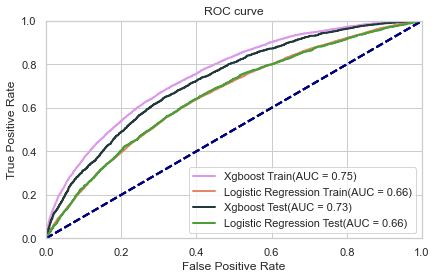

In [99]:
LR_Predict_train = clf_LR.predict_proba(X_train_new)[:,1]
LR_Predict_test = clf_LR.predict_proba(X_test_new)[:,1]

plotAUC(y_train,xgb1.predict_proba(X_train)[:,1], 'Xgboost Train')
plotAUC(y_train,LR_Predict_train,'Logistic Regression Train')
plotAUC(y_test,xgb1.predict_proba(X_test)[:,1], 'Xgboost Test')
plotAUC(y_test,LR_Predict_test,'Logistic Regression Test')
plt.show()

In [108]:
def plotPR(truth, pred, lab):
    precision, recall, thresholds = metrics.precision_recall_curve(truth, pred)
    # f1 = metrics.f1_score(truth, pred)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(recall, precision, color= c,lw=lw, label= lab)
    plt.plot([0,1], [1, 0], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('True Positive Rate')
    plt.ylabel('Positive predictive rate')
    plt.title('Precision recall') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")
# 'lab +'(f1 = %0.2f)' % f1'

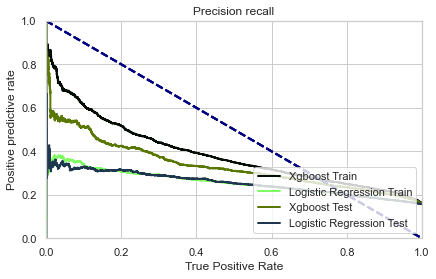

In [109]:
plotPR(y_train,xgb1.predict_proba(X_train)[:,1], 'Xgboost Train')
plotPR(y_train,LR_Predict_train,'Logistic Regression Train')
plotPR(y_test,xgb1.predict_proba(X_test)[:,1], 'Xgboost Test')
plotPR(y_test,LR_Predict_test,'Logistic Regression Test')
plt.show()